<a href="https://colab.research.google.com/github/nasrullah1419/Multiclass-Image-Classification-with-Transfer-Learning/blob/main/Multiclass_Image_Classification_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-datasets

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Download the flowers dataset
ds, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

# Split the dataset into train and validation sets
train_ds = ds['train'].take(int(info.splits['train'].num_examples * 0.8))
val_ds = ds['train'].skip(int(info.splits['train'].num_examples * 0.8))

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Function to preprocess the images
def preprocess(image, label):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing to the datasets
train_data = train_ds.map(preprocess).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_data = val_ds.map(preprocess).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load pretrained MobileNetV2 without the top layer
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base model for initial training

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 flower classes
])


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # sparse labels used in tfds
              metrics=['accuracy'])

# Train the model
initial_history = model.fit(train_data,
                            validation_data=val_data,
                            epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 357ms/step - accuracy: 0.6238 - loss: 0.9919 - val_accuracy: 0.8638 - val_loss: 0.3947
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8537 - loss: 0.4335 - val_accuracy: 0.8760 - val_loss: 0.3509
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8901 - loss: 0.3392 - val_accuracy: 0.8869 - val_loss: 0.2944
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9203 - loss: 0.2596 - val_accuracy: 0.8965 - val_loss: 0.2805
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9269 - loss: 0.2116 - val_accuracy: 0.8992 - val_loss: 0.2801


In [ ]:
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compile again with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(train_data,
                              validation_data=val_data,
                              epochs=5)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.7848 - loss: 0.6272 - val_accuracy: 0.8965 - val_loss: 0.2737
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8828 - loss: 0.3345 - val_accuracy: 0.9033 - val_loss: 0.2602
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9164 - loss: 0.2526 - val_accuracy: 0.9074 - val_loss: 0.2504
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9457 - loss: 0.1810 - val_accuracy: 0.9128 - val_loss: 0.2381
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9535 - loss: 0.1585 - val_accuracy: 0.9101 - val_loss: 0.2310


In [ ]:
# Evaluate the final model on validation data
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9045 - loss: 0.2413
Validation Accuracy: 0.9101


In [ ]:
# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


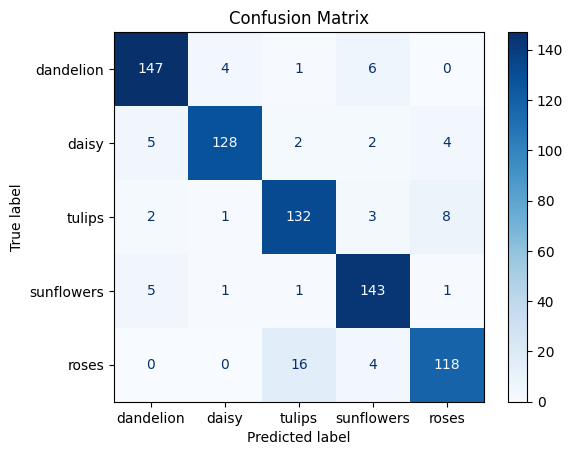

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=info.features['label'].names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Classification report
print(classification_report(y_true, y_pred, target_names=info.features['label'].names))

              precision    recall  f1-score   support

   dandelion       0.92      0.93      0.93       158
       daisy       0.96      0.91      0.93       141
      tulips       0.87      0.90      0.89       146
  sunflowers       0.91      0.95      0.93       151
       roses       0.90      0.86      0.88       138

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734

